In [0]:
import os
import glob
import re
import pandas as pd
import numpy as np
import graphviz 
import pydot
import seaborn as sns
import warnings as warn
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
warn.filterwarnings("ignore")

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
files_path=r'/gdrive/My Drive/Colab Notebooks/DataFiles'
files = glob.glob(os.path.join(files_path,'*.xlsx'))      

In [0]:
print("Total Number of Companies {0}".format(len(files)))

Total Number of Companies 41


In [0]:
appended_data = []
for file in files:
    name = os.path.basename(file).split('.')
    data = pd.read_excel(file,sheet_name='Profit & Loss',skiprows=2,header=None)
    Profit_loss = pd.DataFrame(data)
    Profit_loss = Profit_loss.drop(index=Profit_loss.iloc[Profit_loss.index>16].index,axis=1)
    Profit_loss = Profit_loss.drop(index=Profit_loss.iloc[Profit_loss.index==13].index,axis=1)
    Profit_loss.drop(labels=[11,12,13],axis=1,inplace=True)
    Balance_sheet = pd.read_excel(file,sheet_name='Balance Sheet',skiprows=2,header=None)
    Balance_sheet = pd.DataFrame(Balance_sheet)
    Balance_sheet.drop(index=[0,6,12,16,19],axis=0,inplace=True)
    Altman_Zscore = Profit_loss.append(Balance_sheet,ignore_index=True)
    Altman_Zscore.Transporse = Altman_Zscore.T
    Altman_Zscore.Transporse["Company Name"] = Altman_Zscore.Transporse.apply(lambda row : name[0], axis = 1)
    appended_data.append(Altman_Zscore.Transporse)
    Altman_Zscore_ = pd.concat(appended_data)

In [0]:
Altman_Zscore_.columns= ['Narration','Sales','Expenses','Operating Profit','Other Income','Depreciation','Interest','Profit before tax','Tax','Net profit','EPS','Price to earning','Price','RATIOS','Dividend Payout','OPM','Equity Share Capital','Reserves','Borrowings','Other Liabilities','Total Liabilities','Net Block','Capital Work in Progress','Investments','Other Assets','Total (Assets)','Working Capital','Debtors','Inventory','Debtor Days','Inventory Turnover','Return on Equity','Return on Capital Emp','Company Name']

In [0]:
Altman_Zscore_=Altman_Zscore_.drop(index=Altman_Zscore_.iloc[Altman_Zscore.index==0].index,axis=0)

In [0]:
Altman_Zscore_.reset_index(inplace=True,drop=True)

In [0]:
Altman_Zscore_.drop(columns=['Expenses','Interest', 'Profit before tax', 'Tax','Price to earning', 'RATIOS',  'OPM', 'Equity Share Capital', 'Reserves','Borrowings', 'Net Block','Capital Work in Progress', 'Investments', 'Debtors', 'Inventory','Debtor Days', 'Inventory Turnover', 'Return on Equity','Return on Capital Emp'],axis=0,inplace=True)

In [0]:
EBIT_Derived=[]
Retained_Earnings = []
for i in range(Altman_Zscore_['Narration'].size):
    EBIT_val = (Altman_Zscore_['Operating Profit'][i]-(Altman_Zscore_['Other Income'][i]+Altman_Zscore_['Depreciation'][i]))
    EBIT_Derived.append(EBIT_val)
    Retained_Earnings_val= Altman_Zscore_['Net profit'][i]*(1-Altman_Zscore_['Dividend Payout'][i])
    Retained_Earnings.append(Retained_Earnings_val)
Altman_Zscore_.insert(14,'EBIT',EBIT_Derived,True)     
Altman_Zscore_.insert(15,'Retained Earnings',Retained_Earnings,True)

In [0]:
Altman_Zscore_=Altman_Zscore_.drop(index=Altman_Zscore_[Altman_Zscore_['Sales'] ==0].index,axis=0)
Altman_Zscore_.reset_index(inplace=True,drop=True)

In [0]:
#Class = 0 - Bankruptcy ,Class = 1  - Not Bankruptcy
Altmanzscorederived=[]
Bankruptcy=[]

for i in range(Altman_Zscore_['Narration'].size):
    altzscore = round((1.2*Altman_Zscore_['Working Capital'][i])/Altman_Zscore_['Total (Assets)'][i],4)+round((1.4*Altman_Zscore_['Retained Earnings'][i])/Altman_Zscore_['Total (Assets)'][i],4)+round((3.3*Altman_Zscore_['EBIT'][i])/Altman_Zscore_['Total (Assets)'][i],4)+round((0.6*Altman_Zscore_['EPS'][i]*Altman_Zscore_['Price'][i])/Altman_Zscore_['Total Liabilities'][i],4)+round((1.0*Altman_Zscore_['Sales'][i])/Altman_Zscore_['Total (Assets)'][i],3)      
    Altmanzscorederived.append(altzscore)
    if altzscore <1.8:
        Bankruptcy.append(0)    
    elif np.isnan(altzscore).any():
        Bankruptcy.append('Data Not Available')
    else:
        Bankruptcy.append(1)
        
Altman_Zscore_.insert(16,'Altman_Zscore',Altmanzscorederived,True)
Altman_Zscore_.insert(17,'Bankruptcy',Bankruptcy,True)

In [0]:
Altman_Zscore_Derived_EDA = Altman_Zscore_[Altman_Zscore_['Bankruptcy']!='Data Not Available']
Altman_Zscore_Derived_df = Altman_Zscore_[Altman_Zscore_['Bankruptcy']!='Data Not Available']
Altman_Zscore_Derived_df['Narration'] = pd.to_datetime(Altman_Zscore_Derived_df['Narration'])

In [0]:
Altman_Zscore_df = Altman_Zscore_Derived_df
Altman_Zscore_catg = Altman_Zscore_Derived_df.drop(['Sales', 'Operating Profit', 'Other Income',
       'Depreciation', 'Net profit', 'EPS', 'Price', 'Dividend Payout',
       'Other Liabilities', 'Total Liabilities', 'Other Assets',
       'Total (Assets)', 'Working Capital', 'EBIT', 'Retained Earnings'],axis=1)

In [0]:
Altman_Zscore_df.drop(['Narration','Bankruptcy', 'Company Name','Altman_Zscore'],axis=1,inplace=True)
Altman_Zscore_df = Altman_Zscore_df.apply(zscore)

In [0]:
steelIndustriesData = pd.concat([Altman_Zscore_df,Altman_Zscore_catg],ignore_index=True,axis=1)


In [0]:
steelIndustriesData.columns= ['Sales', 'Operating Profit', 'Other Income',
       'Depreciation', 'Net profit', 'EPS', 'Price', 'Dividend Payout',
       'Other Liabilities', 'Total Liabilities', 'Other Assets',
       'Total (Assets)', 'Working Capital', 'EBIT', 'Retained Earnings','Narration','Altman_Zscore', 'Bankruptcy', 'Company Name']

In [0]:
steelIndustriesData.head(1)

,Sales,Operating Profit,Other Income,Depreciation,Net profit,EPS,Price,Dividend Payout,Other Liabilities,Total Liabilities,Other Assets,Total (Assets),Working Capital,EBIT,Retained Earnings,Narration,Altman_Zscore,Bankruptcy,Company Name
0,-0.391825,-0.334377,0.0217346,-0.39925,0.050247,0.455594,-0.496828,-0.397544,-0.403578,-0.433157,-0.412163,-0.433157,-0.148514,-0.187234,0.06893,2007-03-31,4.0685,1,Rama Steel Tubes


In [0]:
train = []
test = []

listOfCompanies = [str(i) for i in steelIndustriesData['Company Name'].unique()]
for name in listOfCompanies:
    
    head_val = int(round(0.7*len(steelIndustriesData[steelIndustriesData['Company Name']== name])))
    tail_val = len(steelIndustriesData[steelIndustriesData['Company Name']== name])-head_val
    
    train.append(steelIndustriesData[steelIndustriesData['Company Name']== name ].head(n=head_val))
    train_data = pd.concat(train)
    test.append(steelIndustriesData[steelIndustriesData['Company Name']== name ].tail(n=tail_val))
    test_data = pd.concat(test)
    
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

In [0]:
for feature in Altman_Zscore_Derived_EDA.columns: 
    if Altman_Zscore_Derived_EDA[feature].dtype == 'object' : 
        Altman_Zscore_Derived_EDA[feature] = pd.Categorical(Altman_Zscore_Derived_EDA[feature]).codes 
Altman_Zscore_Derived_EDA.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Narration,362.0,8.232044,3.383399,0.0000,5.000000,9.00000,11.0000,14.0000
Sales,362.0,179.375691,103.794717,0.0000,90.250000,178.50000,268.7500,359.0000
Operating Profit,362.0,179.209945,103.932405,0.0000,89.250000,179.50000,268.7500,359.0000
Other Income,362.0,139.500000,87.630781,0.0000,60.000000,129.00000,214.7500,305.0000
Depreciation,362.0,141.679558,97.578618,0.0000,53.250000,137.50000,226.7500,316.0000
Net profit,362.0,162.729282,93.300478,0.0000,89.250000,156.50000,241.7500,332.0000
EPS,362.0,170.408840,99.165793,0.0000,90.250000,167.00000,255.7500,346.0000
Price,362.0,114.165746,94.193736,0.0000,16.250000,106.50000,196.7500,287.0000
Dividend Payout,362.0,10.334254,22.147238,0.0000,0.000000,0.00000,0.0000,86.0000
Other Liabilities,362.0,174.259669,103.712975,0.0000,84.250000,173.50000,263.7500,354.0000


# Bivariate Anlysis

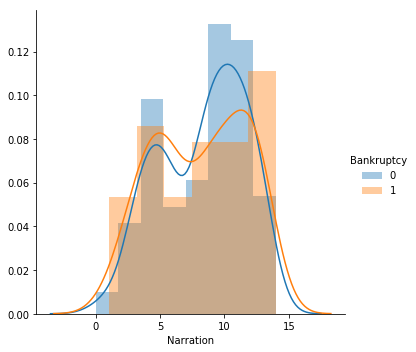

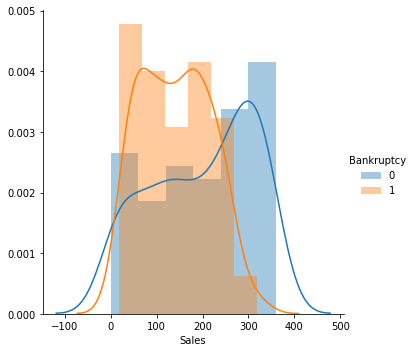

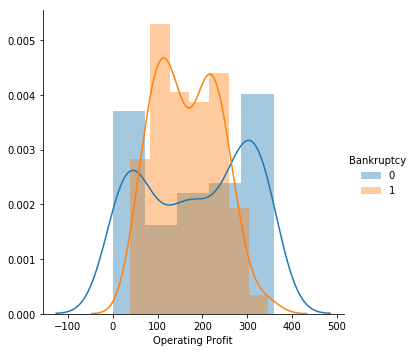

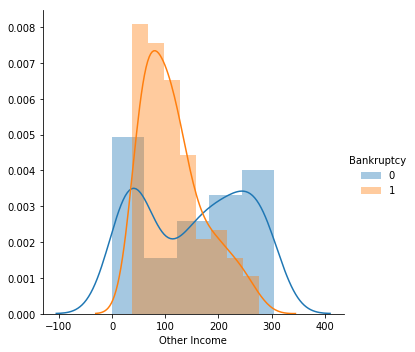

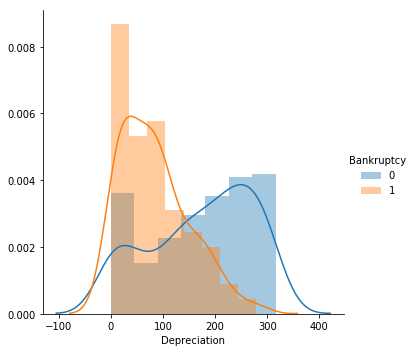

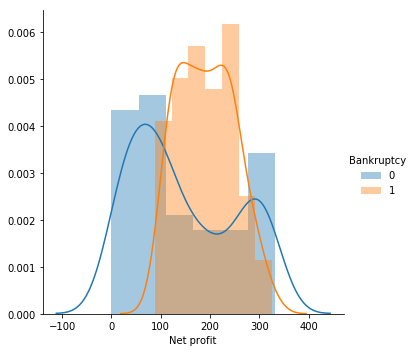

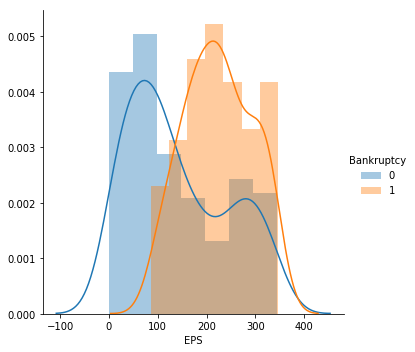

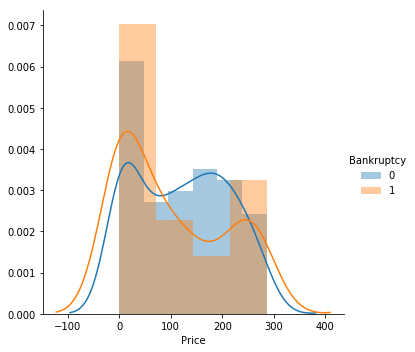

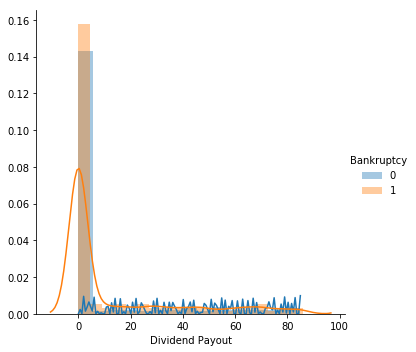

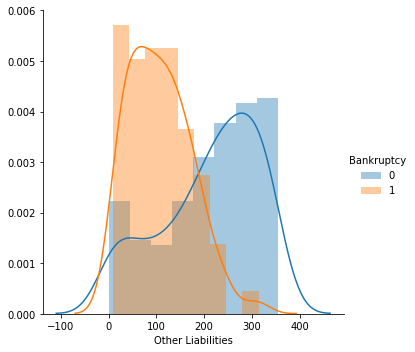

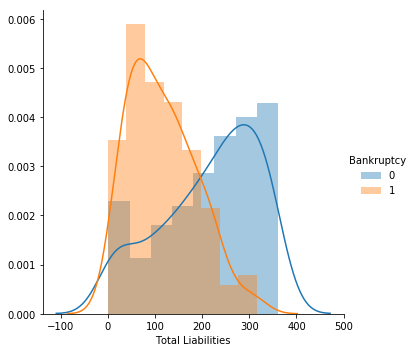

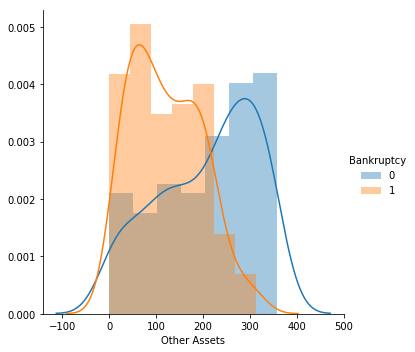

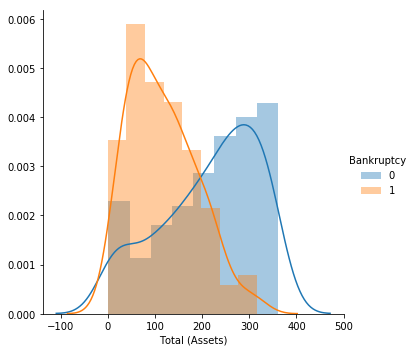

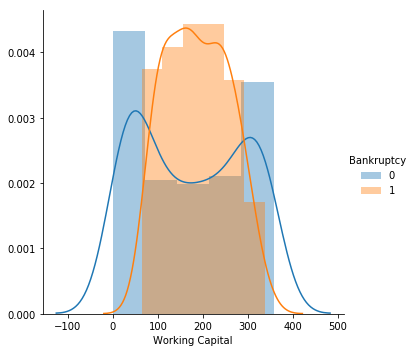

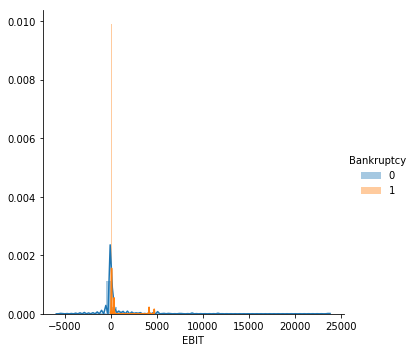

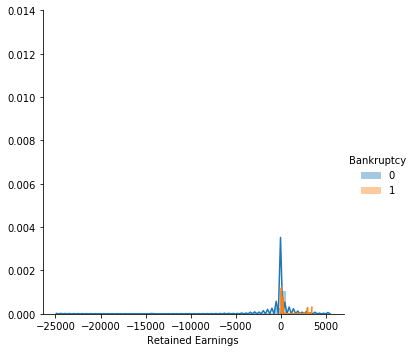

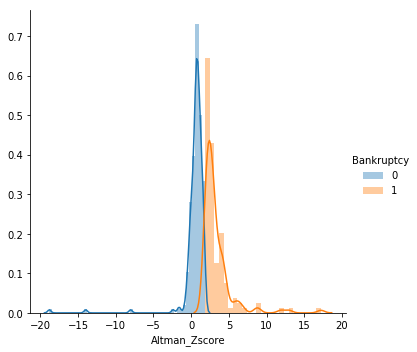

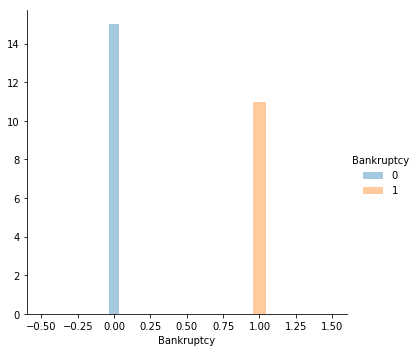

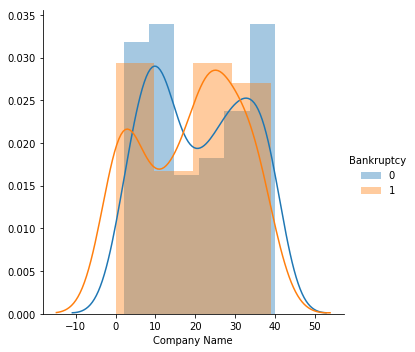

In [0]:
for x in Altman_Zscore_Derived_EDA.columns:
    warn.simplefilter("ignore")
    sns.FacetGrid(Altman_Zscore_Derived_EDA,hue='Bankruptcy',size=5).map(sns.distplot,x).add_legend()

In [0]:
sns.pairplot(Altman_Zscore_Derived_EDA, diag_kind='kde') 

Output hidden; open in https://colab.research.google.com to view.

In [0]:
Altman_Zscore_Derived_EDA.corr()

,Narration,Sales,Operating Profit,Other Income,Depreciation,Net profit,EPS,Price,Dividend Payout,Other Liabilities,Total Liabilities,Other Assets,Total (Assets),Working Capital,EBIT,Retained Earnings,Altman_Zscore,Bankruptcy,Company Name
Narration,1.000000,0.100709,-0.014082,-0.047387,0.090541,-0.181587,-0.180226,0.183966,-0.184175,0.106075,0.109957,0.120447,0.109957,-0.040385,0.033831,-0.211451,0.140671,-0.032323,0.024986
Sales,0.100709,1.000000,0.784020,0.519039,0.922032,0.227839,0.096554,0.522982,0.274731,0.920206,0.927003,0.944502,0.927003,0.409935,0.288242,-0.077405,-0.032080,-0.273482,0.034359
Operating Profit,-0.014082,0.784020,1.000000,0.371841,0.693789,0.476008,0.371240,0.541511,0.380743,0.660460,0.690938,0.708443,0.690938,0.454066,0.372325,0.023320,0.100378,-0.092036,-0.017078
Other Income,-0.047387,0.519039,0.371841,1.000000,0.505566,0.393815,0.298206,0.325323,0.167419,0.507506,0.526287,0.527215,0.526287,0.381793,-0.099548,0.228661,-0.017099,-0.206407,0.151429
Depreciation,0.090541,0.922032,0.693789,0.505566,1.000000,0.107650,-0.036855,0.526786,0.240645,0.943820,0.955134,0.934025,0.955134,0.285287,0.293362,-0.107412,-0.182921,-0.441326,0.047977
Net profit,-0.181587,0.227839,0.476008,0.393815,0.107650,1.000000,0.897375,0.388728,0.512066,0.106624,0.143952,0.179743,0.143952,0.383351,0.178553,0.436779,0.287406,0.237163,0.018375
EPS,-0.180226,0.096554,0.371240,0.298206,-0.036855,0.897375,1.000000,0.283570,0.415305,-0.048919,-0.006979,0.034134,-0.006979,0.336666,0.108391,0.347954,0.385705,0.404475,0.026777
Price,0.183966,0.522982,0.541511,0.325323,0.526786,0.388728,0.283570,1.000000,0.356952,0.448251,0.524082,0.529101,0.524082,0.408961,0.280725,0.141918,0.131333,-0.094334,0.169514
Dividend Payout,-0.184175,0.274731,0.380743,0.167419,0.240645,0.512066,0.415305,0.356952,1.000000,0.218084,0.230181,0.242304,0.230181,0.149681,0.207432,0.191674,0.078562,0.069864,0.031183
Other Liabilities,0.106075,0.920206,0.660460,0.507506,0.943820,0.106624,-0.048919,0.448251,0.218084,1.000000,0.972378,0.964433,0.972378,0.276116,0.275650,-0.099422,-0.216659,-0.482768,-0.011695


In [0]:
#Please use for below dataframe for EDA purpose
Altman_Zscore_Derived_EDA

,Narration,Sales,Operating Profit,Other Income,Depreciation,Net profit,EPS,Price,Dividend Payout,Other Liabilities,Total Liabilities,Other Assets,Total (Assets),Working Capital,EBIT,Retained Earnings,Altman_Zscore,Bankruptcy,Company Name
0,1,100,121,57,40,164,320,0,0,53,64,65,64,139,3.99,1.47,4.0685,1,25
1,3,108,126,144,51,186,341,0,0,61,65,66,65,140,1.81,2.58,3.8618,1,25
2,4,101,118,150,50,185,340,0,0,51,68,68,68,153,-0.16,2.52,2.7136,1,25
3,6,103,114,129,49,124,265,0,0,49,69,70,69,167,-0.14,0.26,2.9996,1,25
4,8,110,112,170,59,156,317,0,0,60,70,69,70,158,-4.13,1.11,3.1569,1,25
5,9,109,123,152,58,178,334,0,0,69,74,74,74,161,-0.21,2.13,3.1077,1,25
6,10,113,124,140,69,144,230,0,0,79,77,81,77,165,0.86,0.69,2.5833,1,25
7,11,116,170,146,77,214,246,233,0,80,79,89,79,172,7.71,5.09,4.7388,1,25
8,12,122,186,151,78,227,262,255,0,92,96,112,96,193,12.37,8.08,6.1593,1,25
9,13,149,192,159,64,231,275,262,0,64,100,109,100,206,13.84,10.59,8.8808,1,25


In [0]:
#Please use for below dataframe for Model building purpose
train_data
test_data
test_data



,Sales,Operating Profit,Other Income,Depreciation,Net profit,EPS,Price,Dividend Payout,Other Liabilities,Total Liabilities,Other Assets,Total (Assets),Working Capital,EBIT,Retained Earnings,Narration,Altman_Zscore,Bankruptcy,Company Name
0,-0.383459,-0.329568,0.0239059,-0.396439,0.0521558,0.071961,0.358071,-0.397544,-0.401655,-0.430537,-0.406899,-0.430537,-0.13782,-0.185231,0.070899,2016-03-31,4.7388,1,Rama Steel Tubes
1,-0.38164,-0.326709,0.0242235,-0.396355,0.0537325,0.095914,0.817095,-0.397544,-0.400602,-0.429507,-0.403081,-0.429507,-0.129135,-0.182721,0.072526,2017-03-31,6.1593,1,Rama Steel Tubes
2,-0.372318,-0.325909,0.0247774,-0.397451,0.0550561,0.114515,1.28995,-0.397544,-0.402941,-0.429199,-0.403564,-0.429199,-0.124227,-0.181929,0.073891,2018-03-31,8.8808,1,Rama Steel Tubes
3,-0.386254,-0.333416,0.0221851,-0.394738,0.0499833,0.0306282,-0.371785,-0.397544,-0.401807,-0.43019,-0.406426,-0.43019,-0.135977,-0.188360,0.068658,2017-03-31,2.3673,1,Rathi Bars
4,-0.380537,-0.332983,0.0219561,-0.394893,0.0502101,0.0344954,-0.247581,-0.397544,-0.402001,-0.43029,-0.406978,-0.43029,-0.137119,-0.187714,0.068892,2018-03-31,3.0640,1,Rathi Bars
5,-0.365269,-0.332428,0.0218527,-0.394092,0.0504579,0.0387222,-0.364134,-0.397544,-0.40219,-0.429564,-0.405989,-0.429564,-0.13361,-0.187407,0.069148,2019-03-31,4.0090,1,Rathi Bars
6,3.22809,-1.91332,0.415973,2.97606,-2.07109,-0.121081,-0.0690312,-0.397544,4.30272,4.08252,4.08311,4.08252,0.641912,-3.300151,-2.119530,2016-03-31,0.1520,0,S A I L
7,3.76292,-0.289275,0.22156,3.36622,-1.44453,-0.0788336,0.102577,-0.397544,4.92734,4.40197,4.69942,4.40197,0.806396,-1.732330,-1.473150,2017-03-31,0.2951,0,S A I L
8,4.99136,1.95133,0.76541,3.9073,-0.204541,0.00477708,0.239144,-0.397544,5.72319,4.79221,5.43829,4.79221,0.875617,-0.162618,-0.193920,2018-03-31,0.4869,0,S A I L
9,0.704147,0.79937,0.0775774,2.03039,-1.70642,-2.09878,-0.12612,-0.397544,0.962237,2.1061,0.298097,2.1061,-1.7175,-0.059218,-1.743322,2016-03-31,-0.0024,0,Tata Steel BSL


# TRAIN AND TEAST DATAFRAME

In [0]:
#train_data

#test_data

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=20):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# Logistic Regression Model Applied For Each Year

In [0]:
traincol = [i for i in train_data.columns.to_list() if i not in ['Narration', 'year','Bankruptcy', 'Company Name','Altman_Zscore']] 
testcol = [i for i in train_data.columns.to_list() if i not in ['Narration', 'year','Bankruptcy', 'Company Name','Altman_Zscore']] 
for feature in traincol: # Loop through all columns in the dataframe
    if train_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        train_data[feature] = pd.to_numeric(train_data[feature]) # Replace strings with an integer
for feature in testcol: # Loop through all columns in the dataframe
    if test_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        test_data[feature] = pd.to_numeric(test_data[feature]) # Replace strings with an integer

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        
X_test_data = test_data
X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
        
y_test = test_data['Bankruptcy']

In [0]:
model = LogisticRegression(penalty='l2',solver='sag')
model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test,model.predict(X_test)))
print(metrics.classification_report(y_test, model.predict(X_test)))


0.7009345794392523
[[63  5]
 [27 12]]
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        68
           1       0.71      0.31      0.43        39

    accuracy                           0.70       107
   macro avg       0.70      0.62      0.61       107
weighted avg       0.70      0.70      0.66       107



In [0]:
metrics_df = metrics.classification_report(y_test, model.predict(X_test),output_dict=True)

In [0]:
precision=[]
for i in range(2):
  precision.append(metrics_df[str(i)]['precision'])

Text(0.5, 1.0, 'precision for each Model')

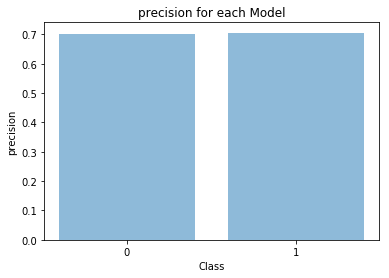

In [0]:

Class = [0,1]
plt.bar(Class, precision,align='center', alpha=0.5)
plt.xticks(Class)
plt.ylabel('precision')
plt.xlabel('Class')
plt.title('precision for each Model')

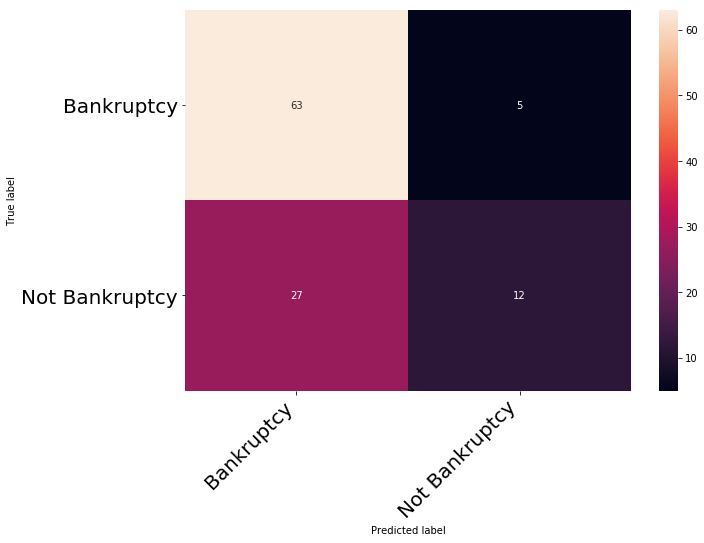

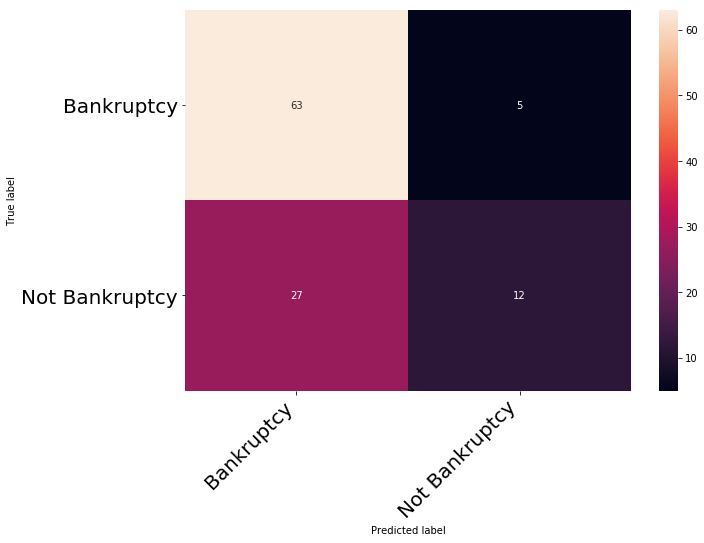

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,model.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

In [0]:
abcl = AdaBoostClassifier(base_estimator=model, n_estimators=50,random_state = 10)
abcl = abcl.fit(X_train, y_train)
abcl.score(X_test , y_test)

0.719626168224299

In [0]:
print(metrics.confusion_matrix(y_test,abcl.predict(X_test)))

[[66  2]
 [28 11]]


In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,abcl.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']


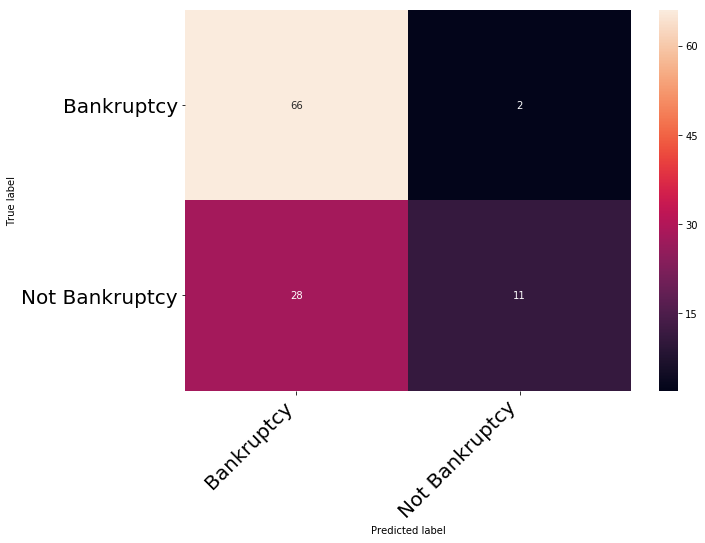

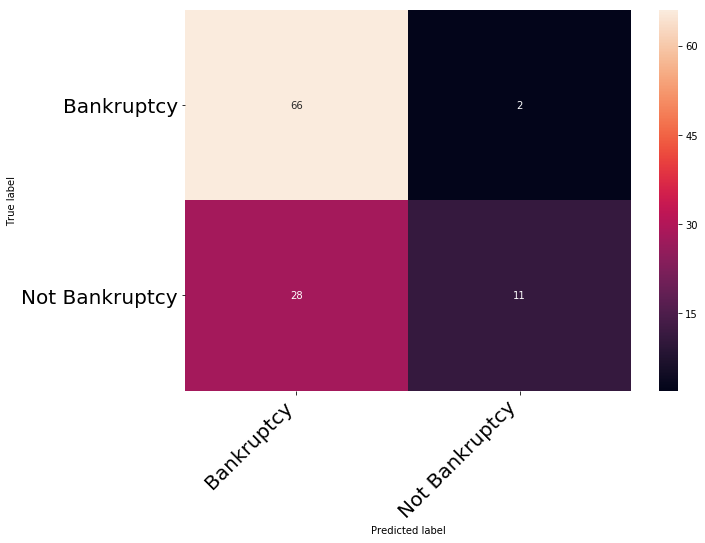

In [0]:
print_confusion_matrix(confusion_matrix,class_names)

# Ensemble - AdaBoosting

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        
X_test_data = test_data
X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       

        
y_test = test_data['Bankruptcy']

In [0]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf=5 )
abcl = AdaBoostClassifier(base_estimator=dt_model, n_estimators=100,random_state = 10)
abcl = abcl.fit(X_train, y_train)
abcl.score(X_test , y_test)

0.9252336448598131

In [0]:
print(metrics.confusion_matrix(y_test,abcl.predict(X_test)))

[[64  4]
 [ 4 35]]


In [0]:
print(metrics.classification_report(y_test, abcl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        68
           1       0.90      0.90      0.90        39

    accuracy                           0.93       107
   macro avg       0.92      0.92      0.92       107
weighted avg       0.93      0.93      0.93       107



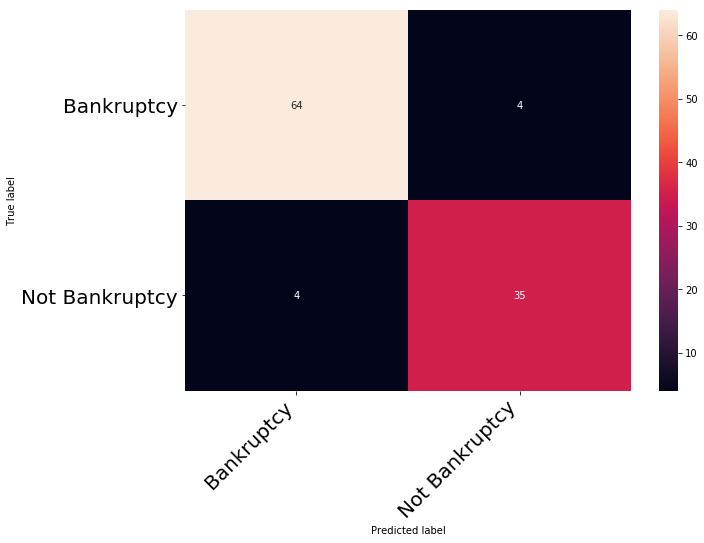

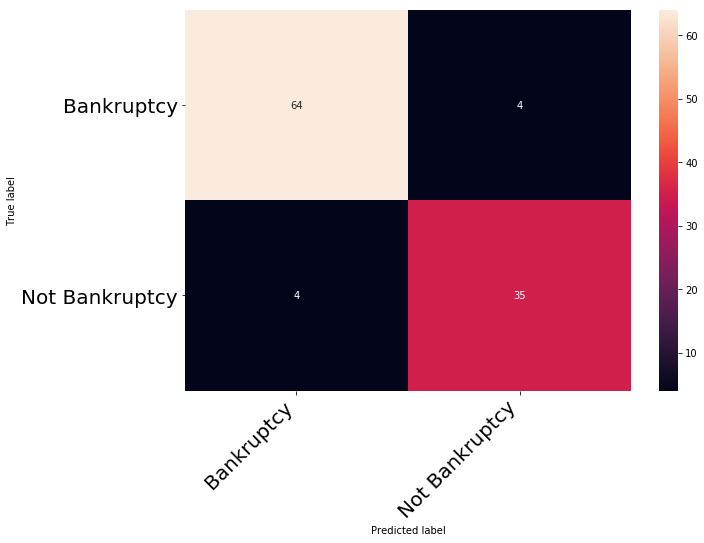

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,abcl.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

In [0]:
print(metrics.confusion_matrix(y_test,abcl.predict(X_test)))
print(metrics.classification_report(y_test, abcl.predict(X_test)))

[[64  4]
 [ 4 35]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        68
           1       0.90      0.90      0.90        39

    accuracy                           0.93       107
   macro avg       0.92      0.92      0.92       107
weighted avg       0.93      0.93      0.93       107



# Decision Tree algorithm

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        
X_test_data = test_data
X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
               
y_test = test_data['Bankruptcy']

In [0]:
DC_model = DecisionTreeClassifier(criterion = 'gini',max_depth =5,max_features=5)

In [0]:
DC_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
DC_model.score(X_test , y_test)

0.8037383177570093

In [0]:
print(metrics.confusion_matrix(y_test,DC_model.predict(X_test)))

[[54 14]
 [ 7 32]]


In [0]:
print(metrics.classification_report(y_test, DC_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        68
           1       0.70      0.82      0.75        39

    accuracy                           0.80       107
   macro avg       0.79      0.81      0.80       107
weighted avg       0.82      0.80      0.81       107



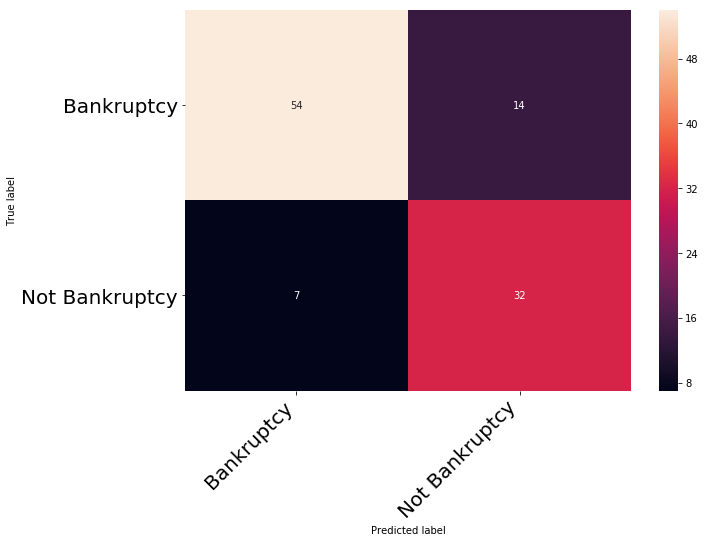

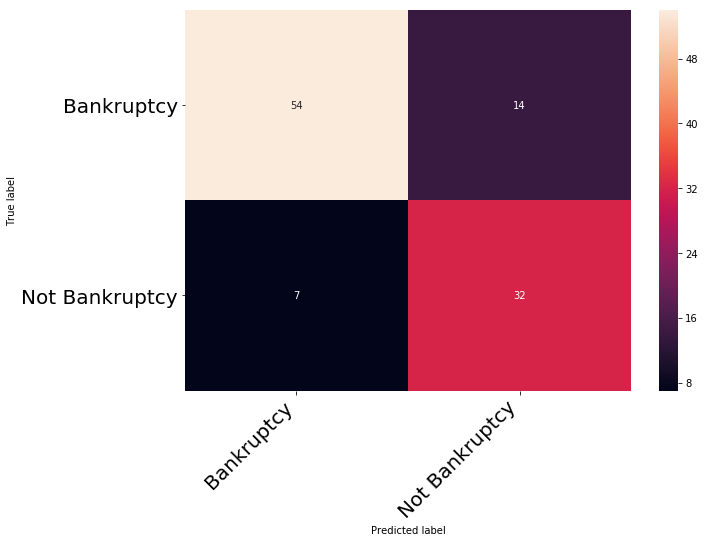

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,DC_model.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

In [0]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [0]:
graph2, = print_tree(DC_model, features=X_train.columns, class_names=['Bankruptcy','Non-Bankruptcy'])

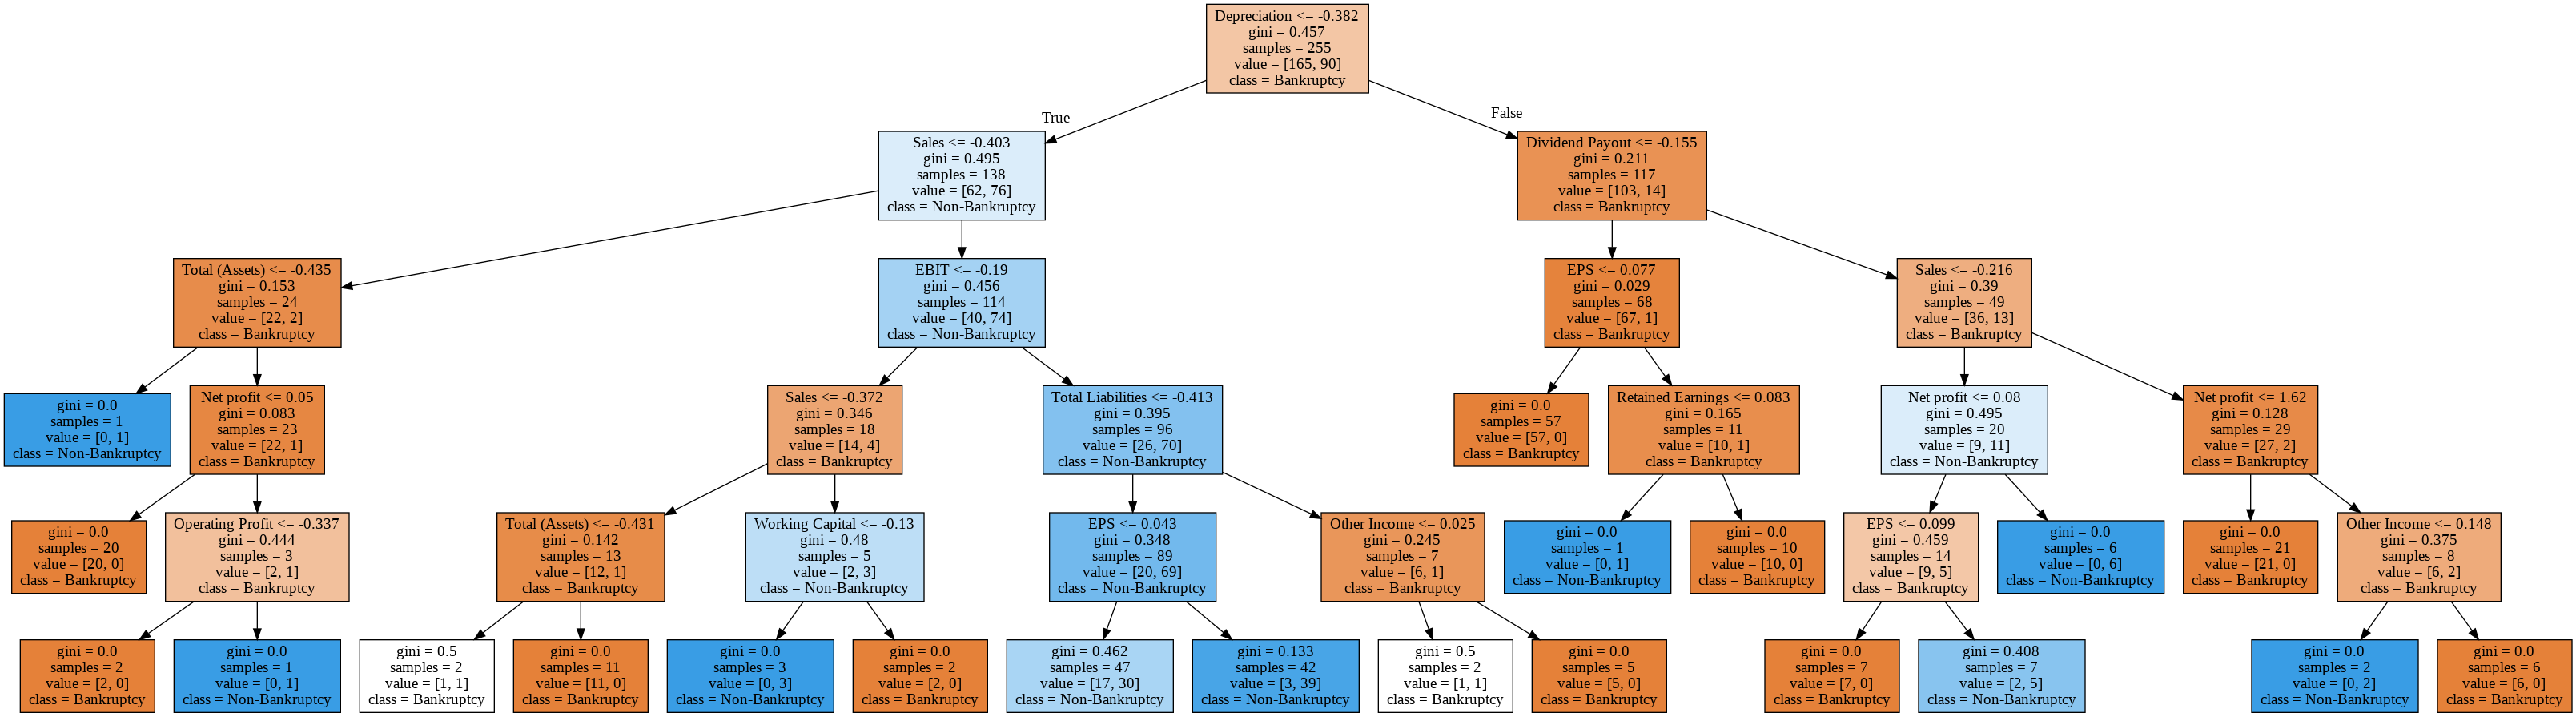

In [0]:
Image(graph2.create_png())

# K Nearest Neighbours

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        

X_test_data = test_data
X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       

        
y_test = test_data['Bankruptcy']

In [0]:
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance')
NNH.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [0]:
NNH.score(X_test,y_test)

0.8411214953271028

In [0]:
# summarize the fit of the model
print(metrics.classification_report(y_test, NNH.predict(X_test)))
print(metrics.confusion_matrix(y_test,NNH.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88        68
           1       0.79      0.77      0.78        39

    accuracy                           0.84       107
   macro avg       0.83      0.83      0.83       107
weighted avg       0.84      0.84      0.84       107

[[60  8]
 [ 9 30]]


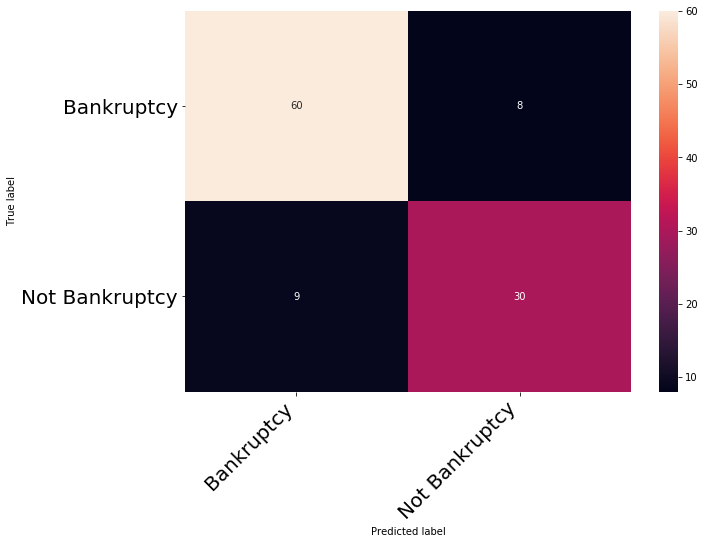

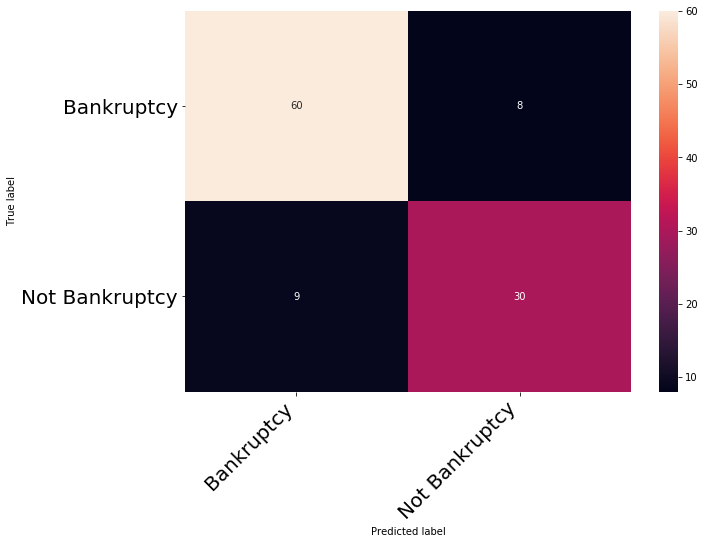

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,NNH.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

# Ensemble - Bagging

In [0]:
bgcl = BaggingClassifier(n_estimators=50,random_state=7)

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        

X_test_data = test_data
X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       
        
y_test = test_data['Bankruptcy']

In [0]:
bgcl = bgcl.fit(X_train, y_train)

In [0]:
bgcl.score(X_train, y_train)

0.996078431372549

In [0]:
bgcl.score(X_test , y_test)

0.9719626168224299

In [0]:
print(metrics.confusion_matrix(y_test,bgcl.predict(X_test)))

[[68  0]
 [ 3 36]]


In [0]:
print(metrics.classification_report(y_test, bgcl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        68
           1       1.00      0.92      0.96        39

    accuracy                           0.97       107
   macro avg       0.98      0.96      0.97       107
weighted avg       0.97      0.97      0.97       107



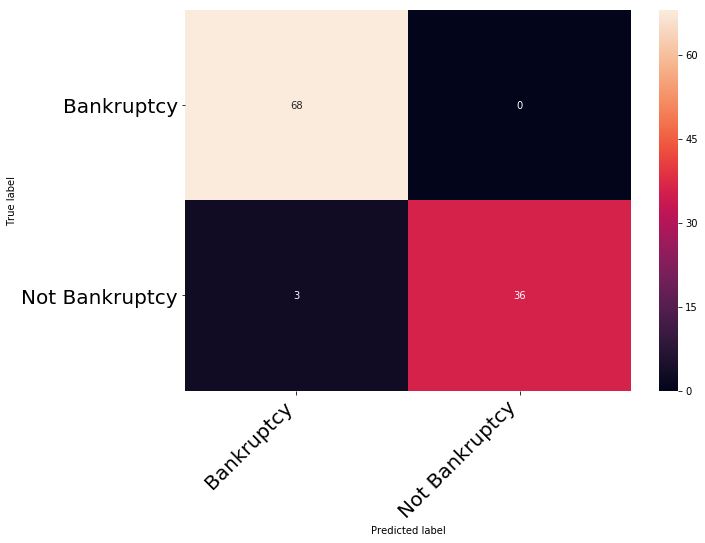

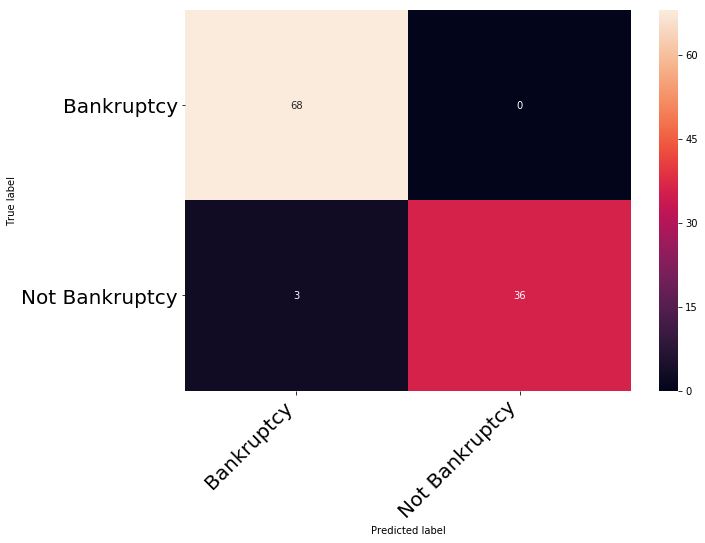

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,bgcl.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(bgcl, X_test, y_test, cv=53)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [1.         1.         1.         1.         1.         0.66666667
 1.         0.66666667 1.         1.         1.         1.
 1.         1.         0.66666667 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.5        1.         1.         1.         1.
 1.         0.5        0.5        1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
Average cross-validation score: 0.95


In [0]:
probs = bgcl.predict_proba(X_test)


In [0]:
probs = probs[:, 0]

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

AUC: 0.017


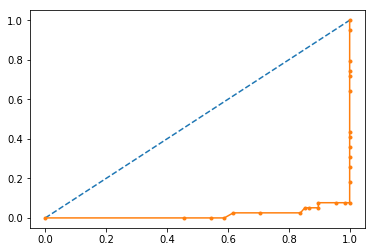

In [0]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# RandomForestClassifier

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
        


X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       
        
y_test = test_data['Bankruptcy']

In [0]:
rfcl = RandomForestClassifier(n_estimators = 100,max_depth=5)

In [0]:
rfcl = rfcl.fit(X_train, y_train)

In [0]:
print(metrics.confusion_matrix(y_test,rfcl.predict(X_test)))

[[62  6]
 [ 3 36]]


In [0]:
rfcl.score(X_test, y_test)

0.9158878504672897

In [0]:
print(metrics.classification_report(y_test, rfcl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        68
           1       0.86      0.92      0.89        39

    accuracy                           0.92       107
   macro avg       0.91      0.92      0.91       107
weighted avg       0.92      0.92      0.92       107



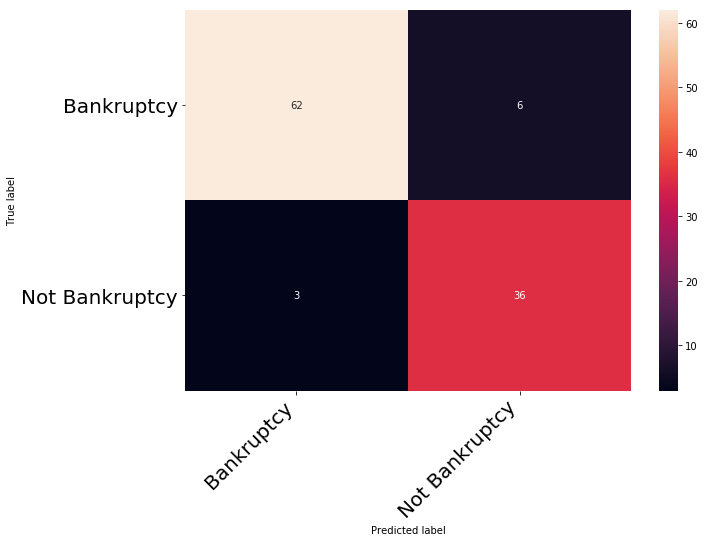

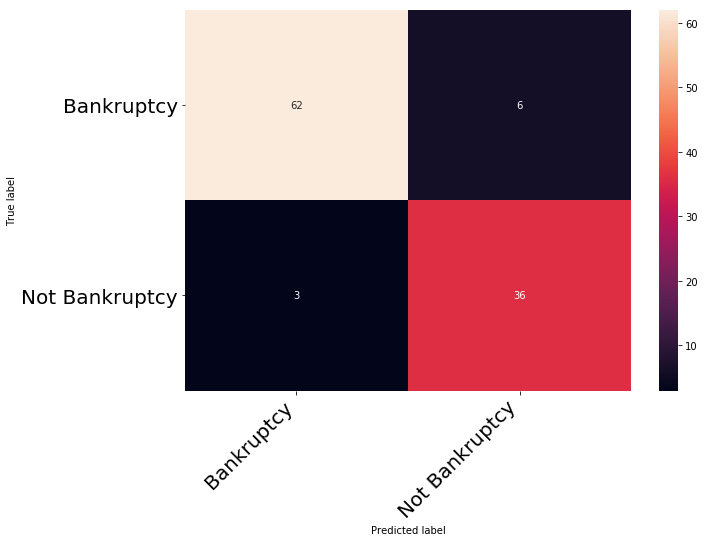

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,rfcl.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

# Naive Bayes Model

In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
   

X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       
        
y_test = test_data['Bankruptcy']

In [0]:
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
predictions=model.predict(X_test)
print(model_score)
#Assess the accuracy of the model on test data
print(metrics.confusion_matrix(y_test,predictions))

0.7009345794392523
[[31 37]
 [ 0 39]]


In [0]:
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        68
           1       0.51      1.00      0.68        39

    accuracy                           0.65       107
   macro avg       0.76      0.73      0.65       107
weighted avg       0.82      0.65      0.65       107



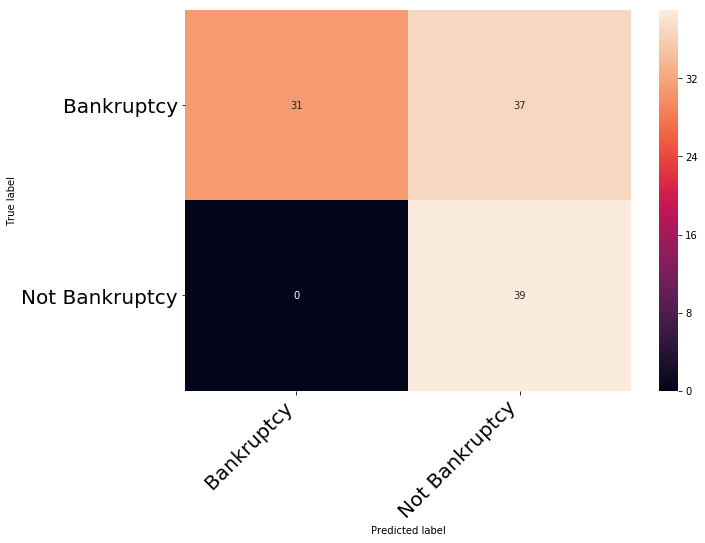

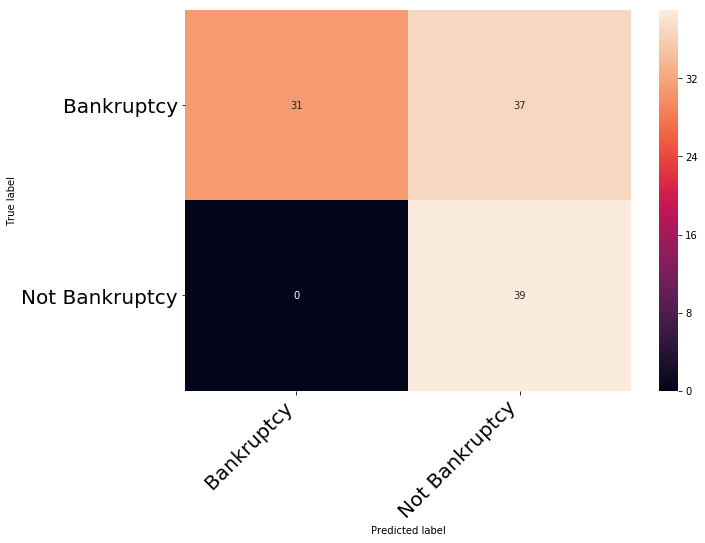

In [0]:
confusion_matrix = metrics.confusion_matrix(y_test,model.predict(X_test))
class_names=['Bankruptcy','Not Bankruptcy']
print_confusion_matrix(confusion_matrix,class_names)

# XG Boost Classifier

In [0]:

from xgboost import XGBClassifier


In [0]:
X_train_data = train_data     
X_train = X_train_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)

y_train = train_data['Bankruptcy']   
   

X_test = X_test_data.drop(['Narration','Bankruptcy','Company Name','Altman_Zscore','Price'],axis=1)
       
        
y_test = test_data['Bankruptcy']

In [0]:

# fit model no training data
xgboost = XGBClassifier(n_estimators=50,importance_type ='total_gain',reg_lambda=2,colsample_bytree=1)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xgboost.score(X_test,y_test)

0.9626168224299065